In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
from mmcls.models.builder import build_classifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import build_dataset, build_dataloader, DATASETS
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import pandas
import json
import seaborn as sns

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results
from scripts.utils.BlurDataset import get_blurred_dataset
from scripts.utils import preprocessing, io
from scripts.utils.model import get_wrongly_classified
from scripts.utils.evaluation import compare_original_blurred
from scripts import evaluate_effectiveness

Importing BlurSegments step into Pipeline


In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'
imgRootTrain = '../data/CompCars_sv_original_split/train'
imgRootVal = '../data/CompCars_sv_original_split/val'
configCAMResOG = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOG = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/latest.pth'
annfileTrain = '../annfileTrain.txt'
annfileVal = '../annfileVal.txt'
annfileValGt = '../annfileValGt.txt'
imgNameTrain='Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgNameVal = 'Acura_Acura_ILX_3c11ef9e42931b.jpg'
imgPathTrain=os.path.join(imgRootTrain, imgNameTrain)
imgPathVal=os.path.join(imgRootVal, imgNameVal)

imgRootValOriginal = '../data/CompCars_sv_original_split/val'
imgRootValColor = '../data/CompCars_sv_color_split/val'
imgRootValWeb = '../data/CompCars_web_original_split/val'

annfileValOriginal = '../data/CompCars_sv_original_split/meta/val.txt'
annfileValColor = '../data/CompCars_sv_color_split/meta/val.txt'
annfileValWeb = '../data/CompCars_web_original_split/meta/val.txt'

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPathOG = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz'
segDataPathNoScaleOG = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScale.npz'

camDataGradCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

dirResOG = 'G:/results/CompCars_original/ResNet'
dirResCol = 'G:/results/CompCars_Color/ResNet'
dirResWeb = 'G:/results/CompCars_Web/ResNet'

dirSwinBaseOG = 'G:/results/CompCars_original/SwinBase'
dirSwinBaseCol = 'G:/results/CompCars_Color/SwinBase'
dirSwinBaseWeb = 'G:/results/CompCars_Web/SwinBase'

dirSwinSmallOG = 'G:/results/CompCars_original/SwinSmall'
dirSwinSmallCol = 'G:/results/CompCars_Color/SwinSmall'
dirSwinSmallWeb = 'G:/results/CompCars_Web/SwinSmall'

In [65]:
imgRootBlurredBackground = '../data/CompCars_sv_original_split/blurred/blurredBackground'
evaluate_effectiveness.evaluate_blurred_background(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG, 
                                                   classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                                   segData=segDataPathNoScaleOG, segConfig=configSeg, saveImgs=False,
                                                   segCheckpoint=checkpointSeg,  saveDir='compareResults/newLoad',
                                                   eval_data_original='./eval_results_original.json',
                                                   imgRootBlurred=imgRootBlurredBackground)

Evaluating original model vs blurred background.
Evaluating original model vs blurred where segments background are blurred.
Created filtered annotation file at compareResults/newLoad\annfile_filtered.txt
Using standard dataset on blurred data at directory ../data/CompCars_sv_original_split/blurred/blurredBackground
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 267.7 task/s, elapsed: 50s, ETA:     0s
Saving json data to compareResults/newLoad\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to compareResults/newLoad\evalBlurred.xlsx
Removing temporary filtered annotation file compareResults/newLoad\annfile_filtered.txt


Using given results from file G:/results/CompCars_original/ResNet\normalized\Data_Full_gradCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx


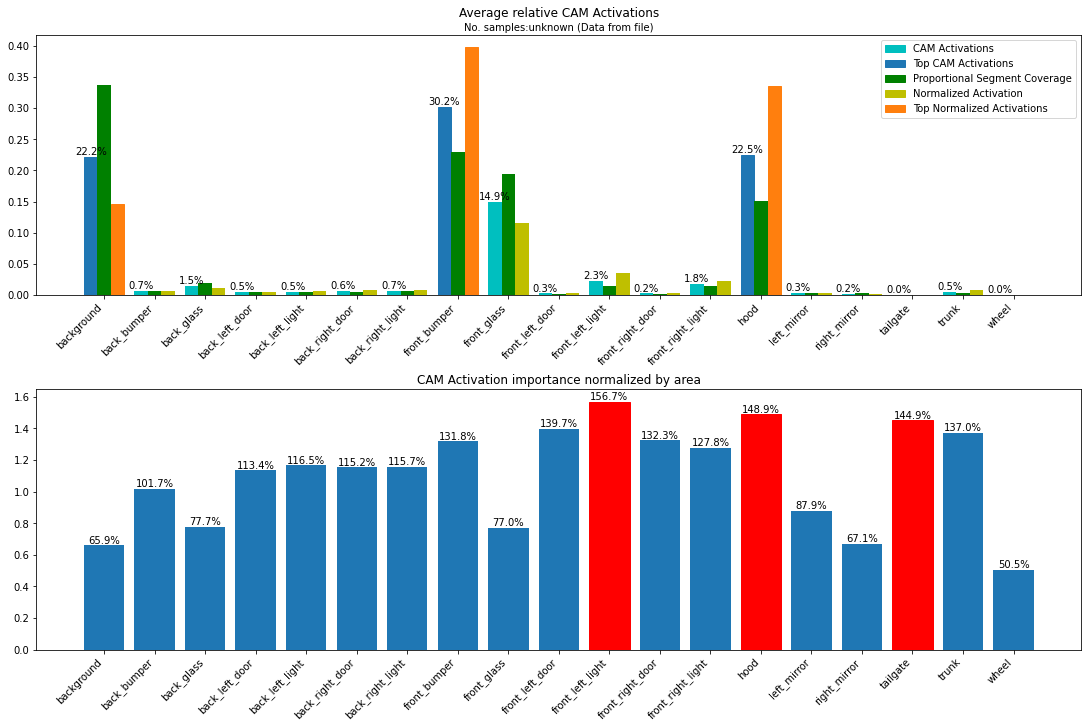

C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\generate_statistics.py:321: UserWarning: No filename is set. Using default: resultsNormalized
  warnings.warn('No filename is set. Using default: resultsNormalized')


Output path is not a directory. Using base directory: conf\normalized.
Saving images to: conf\normalized\resultsNormalized.jpg
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to conf\normalized\normalized_resultsNormalized.xlsx.


In [7]:
resultsFile = os.path.join(dirResOG, 'normalized', 'Data_Full_gradCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx')
generate_statistics.generate_statistic_prop_normalized(saveDir='conf', 
                                                       results_file=resultsFile)

In [6]:
resultsFile = os.path.join(dirResOG, 'normalized', 
                           'Data_Full_gradCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx')
# evaluate_effectiveness.evaluate_blurred_rel_importance(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG,
#                                                       classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
#                                                       segData=segDataPathNoScaleOG, importanceScoreFile=resultsFile, 
#                                                       saveImgs=True, eval_data_original='./eval_results_original.json')
evaluate_effectiveness.evaluate_blurred_normalized_by_rel_importance(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG,
                                                      classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                                      segData=segDataPathNoScaleOG, importanceScoreFile=resultsFile, 
                                                      saveImgs=True, eval_data_original='./eval_results_original.json')

Evaluating original model vs blurred relative Importance with top 3 blurred.
Blurring 3 segments out of 19.
Blurring segment with index 7,13,0
Blurring segments front_bumper,hood,background
Evaluating original model vs blurred where segments [7, 13, 0] are blurred.
Created filtered annotation file at ./annfile_filtered.txt
Computing blurred images on demand.
Setting up configs for Blurred Dataset
Blurred Images will be saved to ./blurredImgs
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[                                                  ] 0/13333, elapsed: 0s, ETA:

KeyboardInterrupt: 

In [4]:
resultsFile = os.path.join(dirResOG, 'normalized', 
                           'Data_Full_gradCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx')

evaluate_effectiveness.evaluate_blurred_rel_importance(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG,
                                                      classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                                      segData=segDataPathNoScaleOG, importanceScoreFile=resultsFile, 
                                                      saveImgs=True, saveDir='randomBlurLess', randomBlur=True,
                                                      eval_data_original='./eval_results_original.json')

Evaluating original model vs blurred relative Importance with top 3 blurred.
Blurring 3 segments out of 19.
Blurring segment with index 10,13,16
Blurring segments front_left_light,hood,tailgate
Evaluating original model vs blurred where segments [10, 13, 16] are blurred.
Created filtered annotation file at randomBlurLess\annfile_filtered.txt
Computing blurred images on demand.
Setting up configs for Blurred Dataset
Blurring random parts of the image
Blurred Images will be saved to randomBlurLess\blurredImgs
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 23.8 task/s, elapsed: 561s, ETA:     0s
Saving json data to randomBlurLess\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to randomBlurLess\evalBlurred.xlsx
Removing temporary filtered annotation file randomBlurLess